<!-- import sys
import os

# This gets the absolute path to the 'deliverabels' directory
project_root = os.path.abspath(os.path.join('..'))

if project_root not in sys.path:
    sys.path.append(project_root)

from ml_pipeline import pipeline -->

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from ml_pipeline.pipeline import run_pipeline


In [11]:
df = pd.read_csv("featured_housing.csv")

df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,log_MedInc,log_Population,...,MedInc_bin,HouseAge_bin,Population_bin,AveRooms_bin,people_per_room,income_per_room,population_per_age,dist_to_coast,dist_to_center,MedHouseVal
0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.181605,7.740664,...,2,3,4,2,0.735764,0.649626,69.696968,2.97,4.523826,1.030
1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,1.338285,7.180831,...,2,4,2,1,0.388527,0.852232,26.816326,1.84,3.041135,3.821
2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.424625,6.818924,...,3,0,1,3,0.482340,0.736171,228.749943,0.48,2.084706,1.726
3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.663976,7.257003,...,0,3,3,0,0.997889,0.485283,39.388888,2.89,4.497577,0.934
4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,1.268130,6.773080,...,2,4,1,3,0.366918,0.567001,20.325581,0.20,0.410366,0.965


In [12]:
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

X.shape, y.shape


((20640, 51), (20640,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [14]:
X_train.shape[1]


51

# Baseline
## all engineered baseline

In [15]:
all_features = X_train.columns.tolist()

baseline_metrics, baseline_errors = run_pipeline(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model=LinearRegression(),
    numerical_cols=all_features,
    categorical_cols=[],
    task_type="regression"
)

baseline_metrics


{'train': {'rmse': 0.6165921497065796, 'mae': 0.44338422049453036},
 'test': {'rmse': 0.6218454482977998, 'mae': 0.4452817983938634}}

In [16]:
baseline_rmse = baseline_metrics["test"]["rmse"]
baseline_mae = baseline_metrics["test"]["mae"]

baseline_rmse, baseline_mae


(0.6218454482977998, 0.4452817983938634)

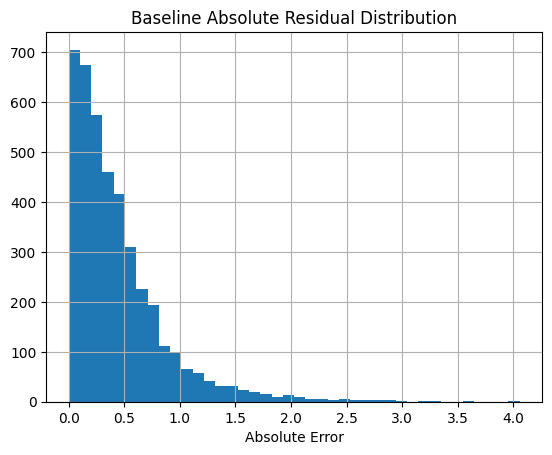

In [ ]:
plt.figure()
baseline_errors["abs_residual"].hist(bins=40)
baseline_errors["abs_residual"].hist(bins=40)
plt.title("Baseline Absolute Residual Distribution")
plt.xlabel("Absolute Error")
plt.show()


In [19]:
feature_groups = {
    "raw": [
        "MedInc", "HouseAge", "AveRooms", "AveBedrms",
        "Population", "AveOccup", "Latitude", "Longitude"
    ],

    "transforms": [
        col for col in X.columns
        if col.startswith(("log_", "sqrt_", "inv_")) or col.endswith("_sq")
    ],

    "ratios": [
        "rooms_per_person", "bedrooms_per_room",
        "income_per_person", "people_per_room",
        "income_per_room", "population_per_age"
    ],

    "differences": [
        "rooms_minus_bedrooms", "age_income_gap"
    ],

    "binary_flags": [
        "high_income", "old_house", "high_population"
    ],

    "geo_bins": [
        "lat_region", "lon_region"
    ],

    "geo_clusters": [
        "geo_cluster"
    ],

    "aggregates": [
        "size_score", "crowding_score", "geo_score"
    ],

    "interactions": [
        "income_x_rooms", "age_x_rooms", "lat_x_lon"
    ],

    "quantile_bins": [
        "MedInc_bin", "HouseAge_bin",
        "Population_bin", "AveRooms_bin"
    ],

    "distance_features": [
        "dist_to_coast", "dist_to_center"
    ]
}


In [20]:
ablation_results = []

for group_name, group_features in feature_groups.items():
    remaining_features = [
        f for f in all_features if f not in group_features
    ]

    metrics, _ = run_pipeline(
        X_train=X_train[remaining_features],
        X_test=X_test[remaining_features],
        y_train=y_train,
        y_test=y_test,
        model=LinearRegression(),
        numerical_cols=remaining_features,
        categorical_cols=[],
        task_type="regression"
    )

    ablation_results.append({
        "Ablated Group": group_name,
        "Test RMSE": metrics["test"]["rmse"],
        "Δ RMSE": metrics["test"]["rmse"] - baseline_rmse,
        "Test MAE": metrics["test"]["mae"],
        "Δ MAE": metrics["test"]["mae"] - baseline_mae
    })

ablation_df = pd.DataFrame(ablation_results)
ablation_df


,Ablated Group,Test RMSE,Δ RMSE,Test MAE,Δ MAE
0,raw,0.629799,7.953777e-03,0.452866,7.584136e-03
1,transforms,0.631266,9.420552e-03,0.452392,7.110323e-03
2,ratios,0.633103,1.125729e-02,0.457367,1.208563e-02
3,differences,0.621845,-2.220446e-16,0.445282,1.110223e-16
4,binary_flags,0.622638,7.925221e-04,0.446546,1.264245e-03
5,geo_bins,0.624385,2.539285e-03,0.445831,5.487456e-04
6,geo_clusters,0.625226,3.380142e-03,0.448741,3.459194e-03
7,aggregates,0.621845,-4.440892e-16,0.445282,6.661338e-16
8,interactions,0.626956,5.110102e-03,0.449862,4.579759e-03
9,quantile_bins,0.622951,1.105413e-03,0.446965,1.683392e-03


In [21]:
ablation_df.sort_values("Δ RMSE", ascending=False)


,Ablated Group,Test RMSE,Δ RMSE,Test MAE,Δ MAE
10,distance_features,0.635342,1.349685e-02,0.457640,1.235833e-02
2,ratios,0.633103,1.125729e-02,0.457367,1.208563e-02
1,transforms,0.631266,9.420552e-03,0.452392,7.110323e-03
0,raw,0.629799,7.953777e-03,0.452866,7.584136e-03
8,interactions,0.626956,5.110102e-03,0.449862,4.579759e-03
6,geo_clusters,0.625226,3.380142e-03,0.448741,3.459194e-03
5,geo_bins,0.624385,2.539285e-03,0.445831,5.487456e-04
9,quantile_bins,0.622951,1.105413e-03,0.446965,1.683392e-03
4,binary_flags,0.622638,7.925221e-04,0.446546,1.264245e-03
3,differences,0.621845,-2.220446e-16,0.445282,1.110223e-16


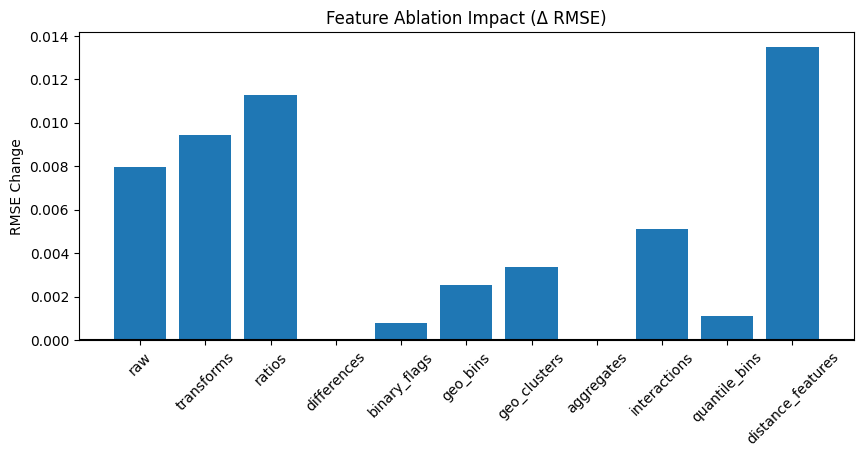

In [22]:
plt.figure(figsize=(10,4))
plt.bar(ablation_df["Ablated Group"], ablation_df["Δ RMSE"])
plt.axhline(0, color="black")
plt.xticks(rotation=45)
plt.title("Feature Ablation Impact (Δ RMSE)")
plt.ylabel("RMSE Change")
plt.show()


In [29]:

worst_group = ablation_df.sort_values("Δ RMSE", ascending=False).iloc[0]["Ablated Group"]
worst_group, best_group


('distance_features', 'aggregates')

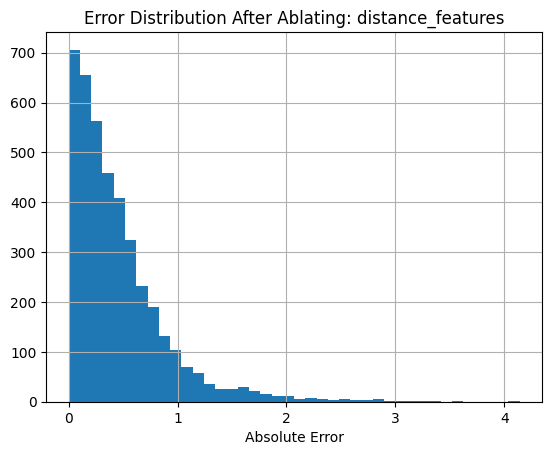

In [30]:
remaining_worst = [
    f for f in all_features if f not in feature_groups[worst_group]
]

_, worst_errors = run_pipeline(
    X_train=X_train[remaining_worst],
    X_test=X_test[remaining_worst],
    y_train=y_train,
    y_test=y_test,
    model=LinearRegression(),
    numerical_cols=remaining_worst,
    categorical_cols=[],
    task_type="regression"
)

plt.figure()
worst_errors["abs_residual"].hist(bins=40)
plt.title(f"Error Distribution After Ablating: {worst_group}")
plt.xlabel("Absolute Error")
plt.show()


In [33]:
key_features = [
    "MedHouseVal",
    "MedInc", "HouseAge", "AveRooms", "Population",
    "log_MedInc", "income_per_room",
    "dist_to_coast", "dist_to_center",
    "geo_cluster",
    "rooms_per_person"
]

corr_focus = df[key_features].corr()


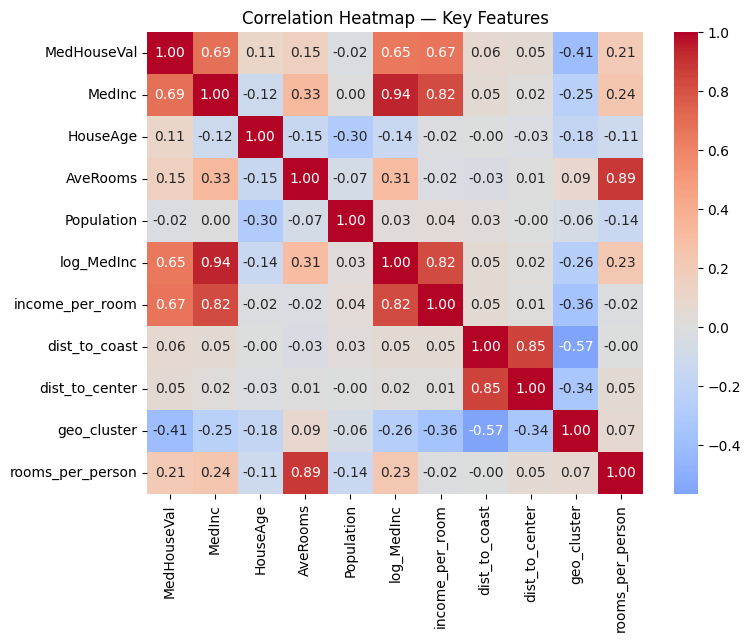

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_focus,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap — Key Features")
plt.show()
